# Regularization
I'm following the guide here: <https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html>.

## Load Data

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (20, 20), 'figure.dpi': 300}
)

In [166]:
from common.data import get_data

X, Y, demographics = get_data()
ages, sexes, diagnosis = demographics['Age'], demographics['Sex'], demographics['Diagnosis']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Sex: {sexes.shape} | Diagnosis: {diagnosis.shape}')

X: (594, 34716) | Y: 16 | Age: (594,) | Sex: (594,) | Diagnosis: (594,)


In [149]:
selected_target = "WISC_PSI"
y = Y[selected_target]

print(f'y: {y.shape}')

y: (594,)


## Feature selection

### Age Binning

In [150]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages, y)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 0 Range: 6.03 -> 8.98
Bin 1 Range: 9.04 -> 11.96
Bin 2 Range: 12.03 -> 15.98
---
Bin 0 Range: 45.00 -> 148.00
Bin 1 Range: 45.00 -> 135.00
Bin 2 Range: 49.00 -> 144.00
---
Bin 1: (185, 34716) | Bin 2: (231, 34716) | Bin 3: (178, 34716)


## Ridge Model

In [5]:
from scipy import stats
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

In [168]:
X_cv = X
y_cv = y

estimators = [StandardScaler(), RidgeCV(alphas=[a for a in range(5000, 7000, 5000)], cv=rkf)]
pipe = make_pipeline(*estimators)

pipe.fit(X_cv, y_cv)
ridge_cv = pipe['ridgecv']

print(ridge_cv.alpha_)
print(ridge_cv.best_score_)

6900
0.5095827330939503


In [169]:
def regression_scorer(reg, X, y):
    y_pred = reg.predict(X)
    return {'r2': r2_score(y, y_pred), 'pearsonr': stats.pearsonr(y, y_pred)[0],
            'spearmanr': stats.spearmanr(y, y_pred)[0]}

estimators = [StandardScaler(), Ridge(alpha=ridge_cv.alpha_)]
pipe = make_pipeline(*estimators)

scoring = ['train_r2', 'test_r2', 'test_pearsonr', 'test_spearmanr']
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=251183)

In [170]:
%%time
scores = cross_validate(pipe, X_cv, y_cv, cv=rkf, scoring=regression_scorer, n_jobs=-1, 
                        return_train_score=True, return_estimator=True)

coefs = [estimator['ridge'].coef_ for estimator in scores['estimator']]
avg_coef = np.mean(coefs, axis=0)

print(f'Target: {selected_target}')
for metric in scoring:
    metric_values = scores[metric]
    print(f'Avg {metric}: {np.mean(metric_values):.3f}')

Target: WISC_PSI
Avg train_r2: 0.943
Avg test_r2: 0.510
Avg test_pearsonr: 0.722
Avg test_spearmanr: 0.714
CPU times: user 1.07 s, sys: 540 ms, total: 1.61 s
Wall time: 11.9 s


## Analyze Ridge Coefficients

### Plot

(34716,) -0.12795971 0.11846963


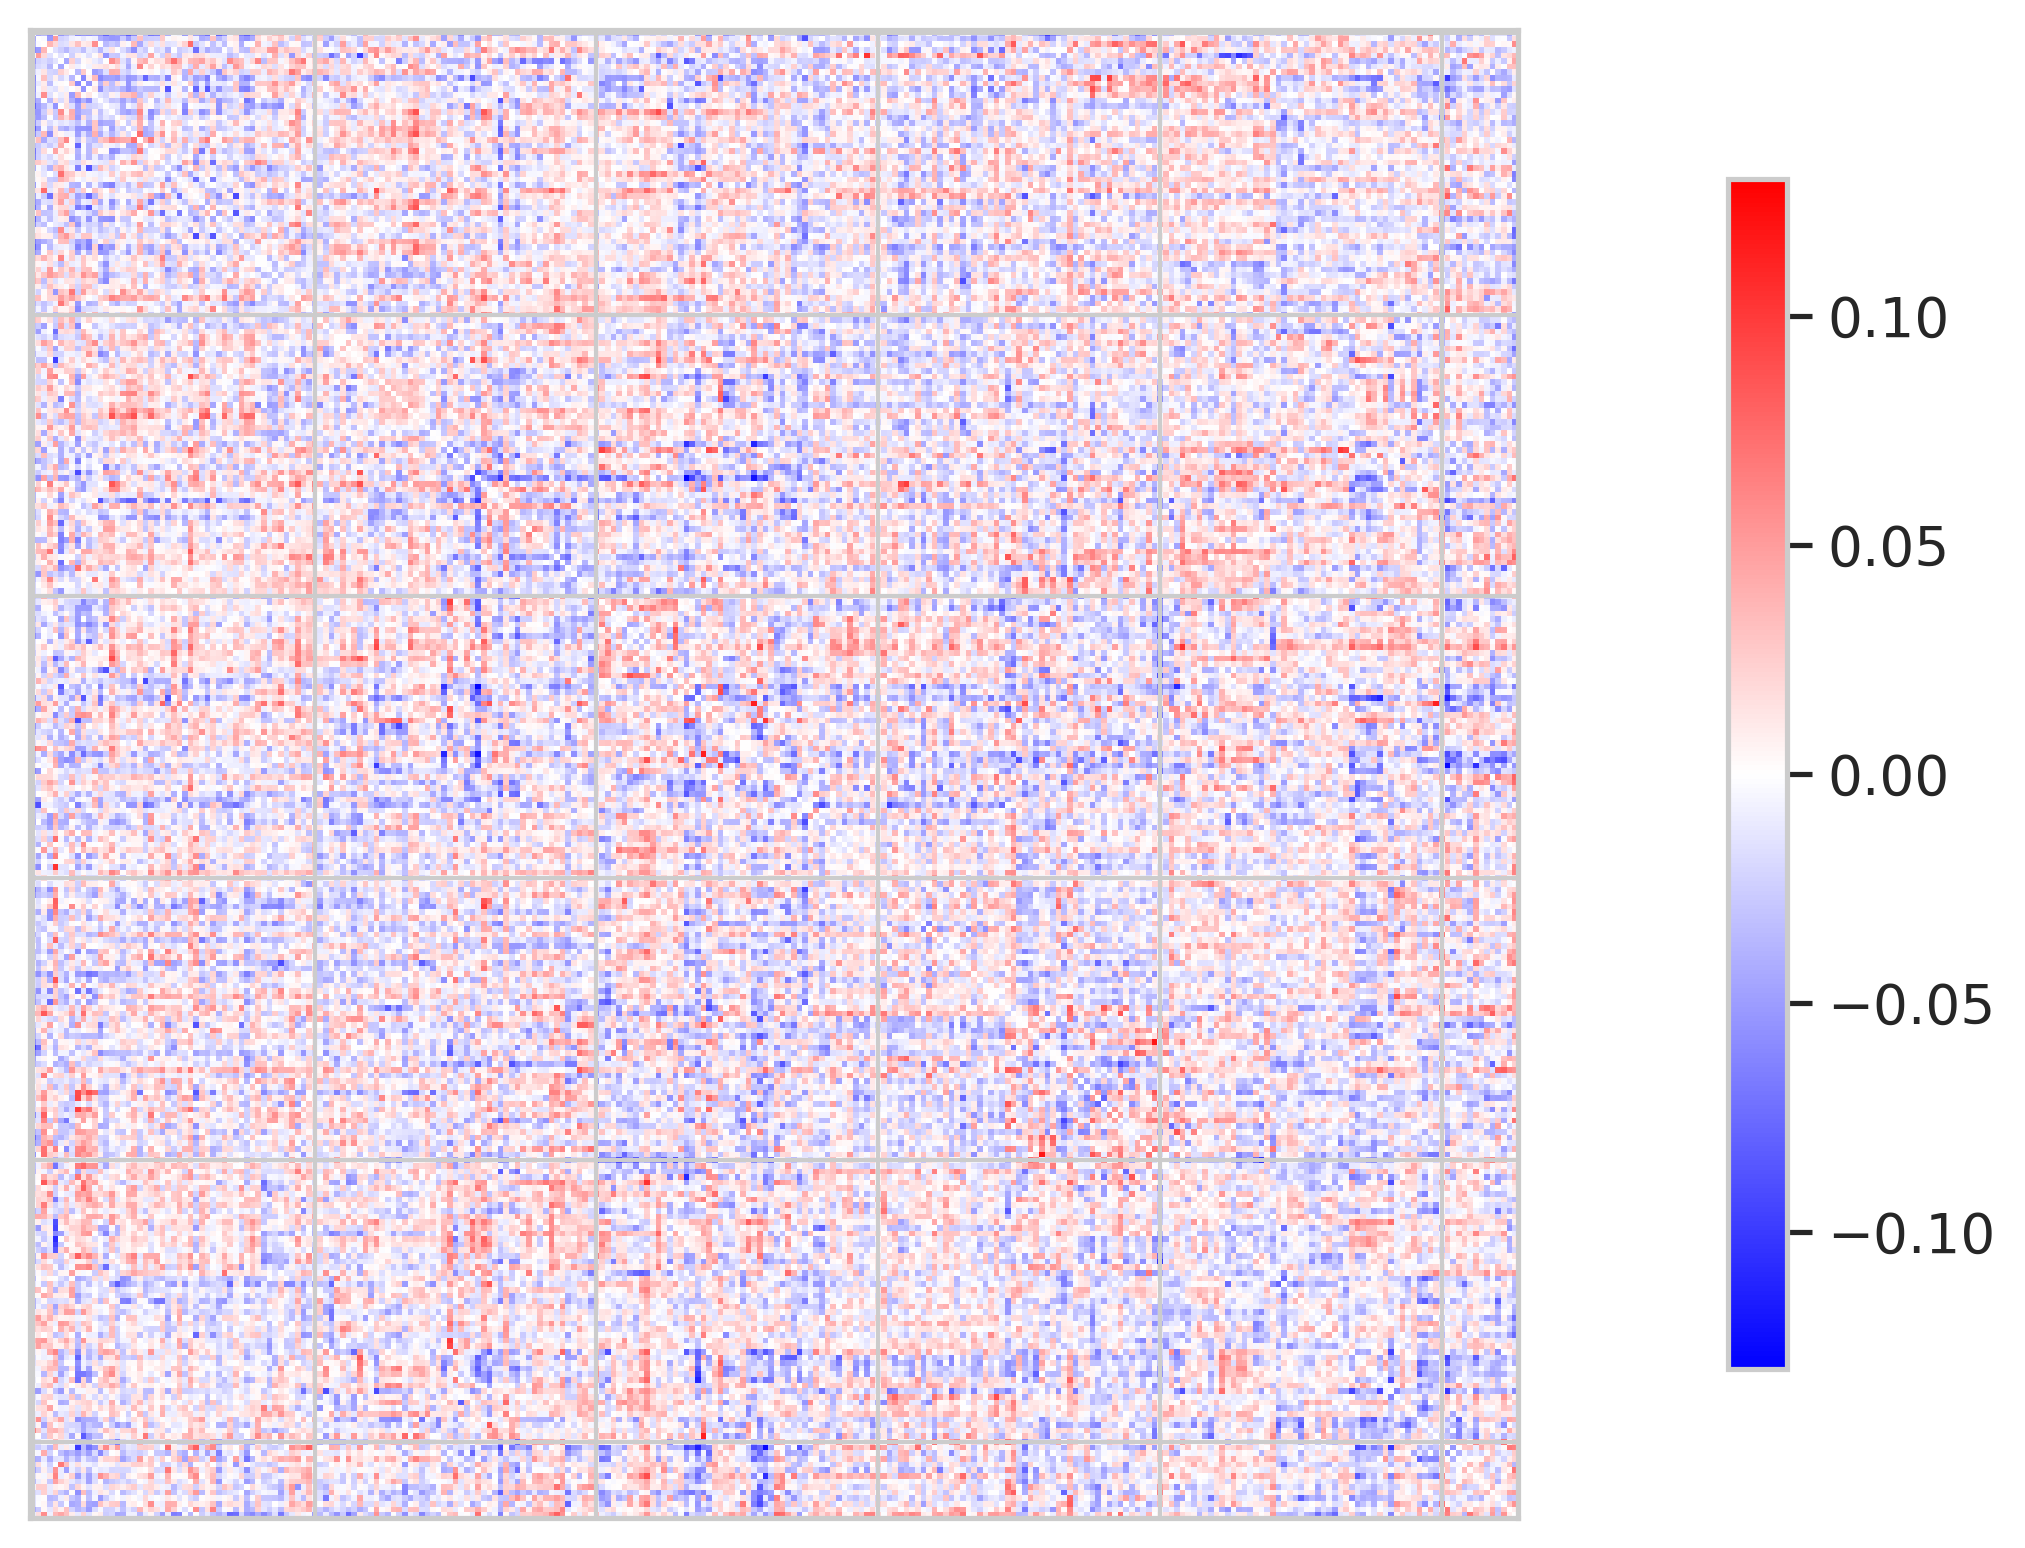

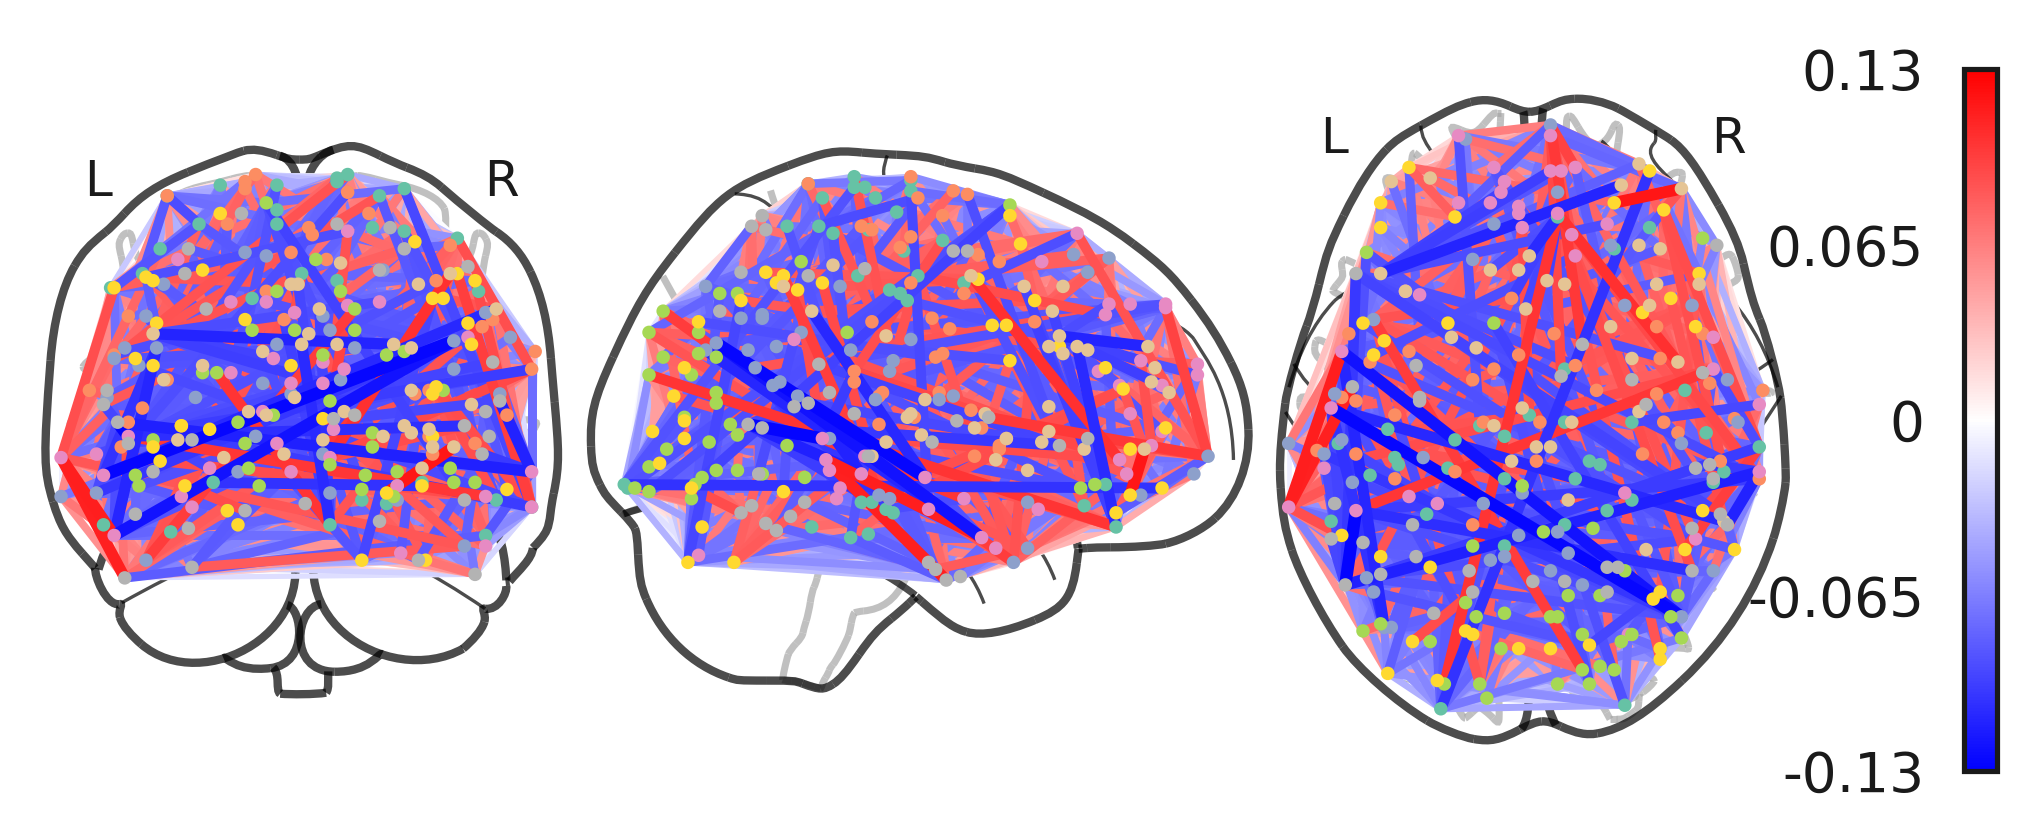

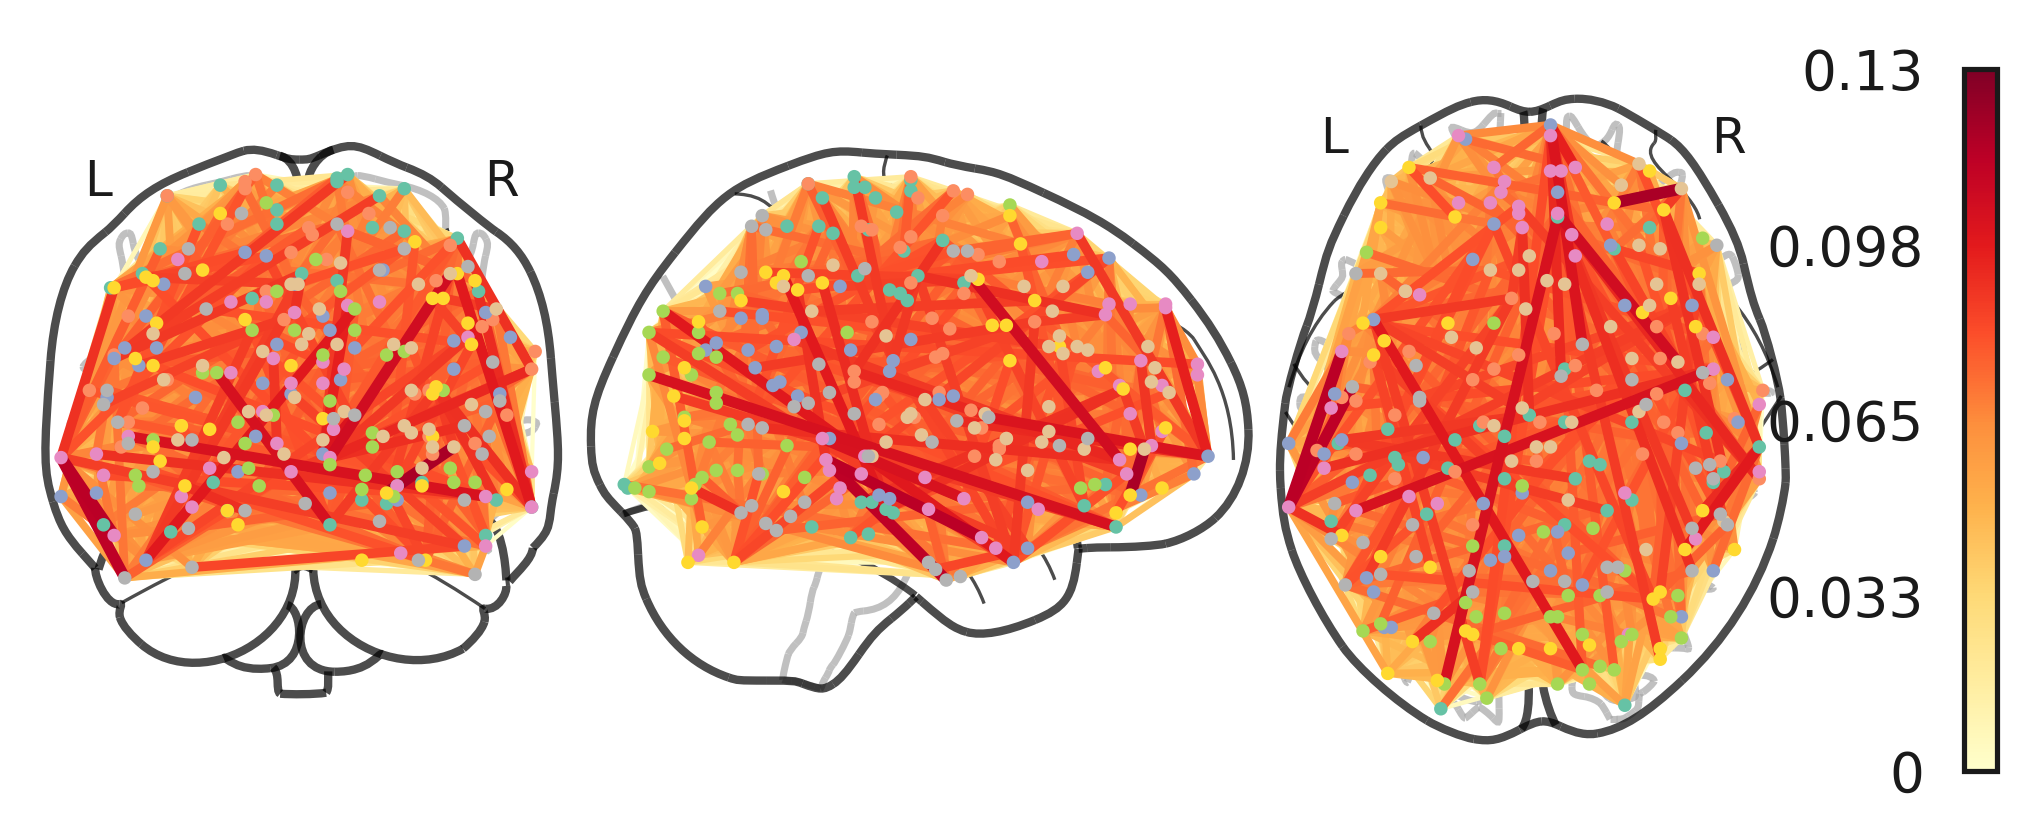

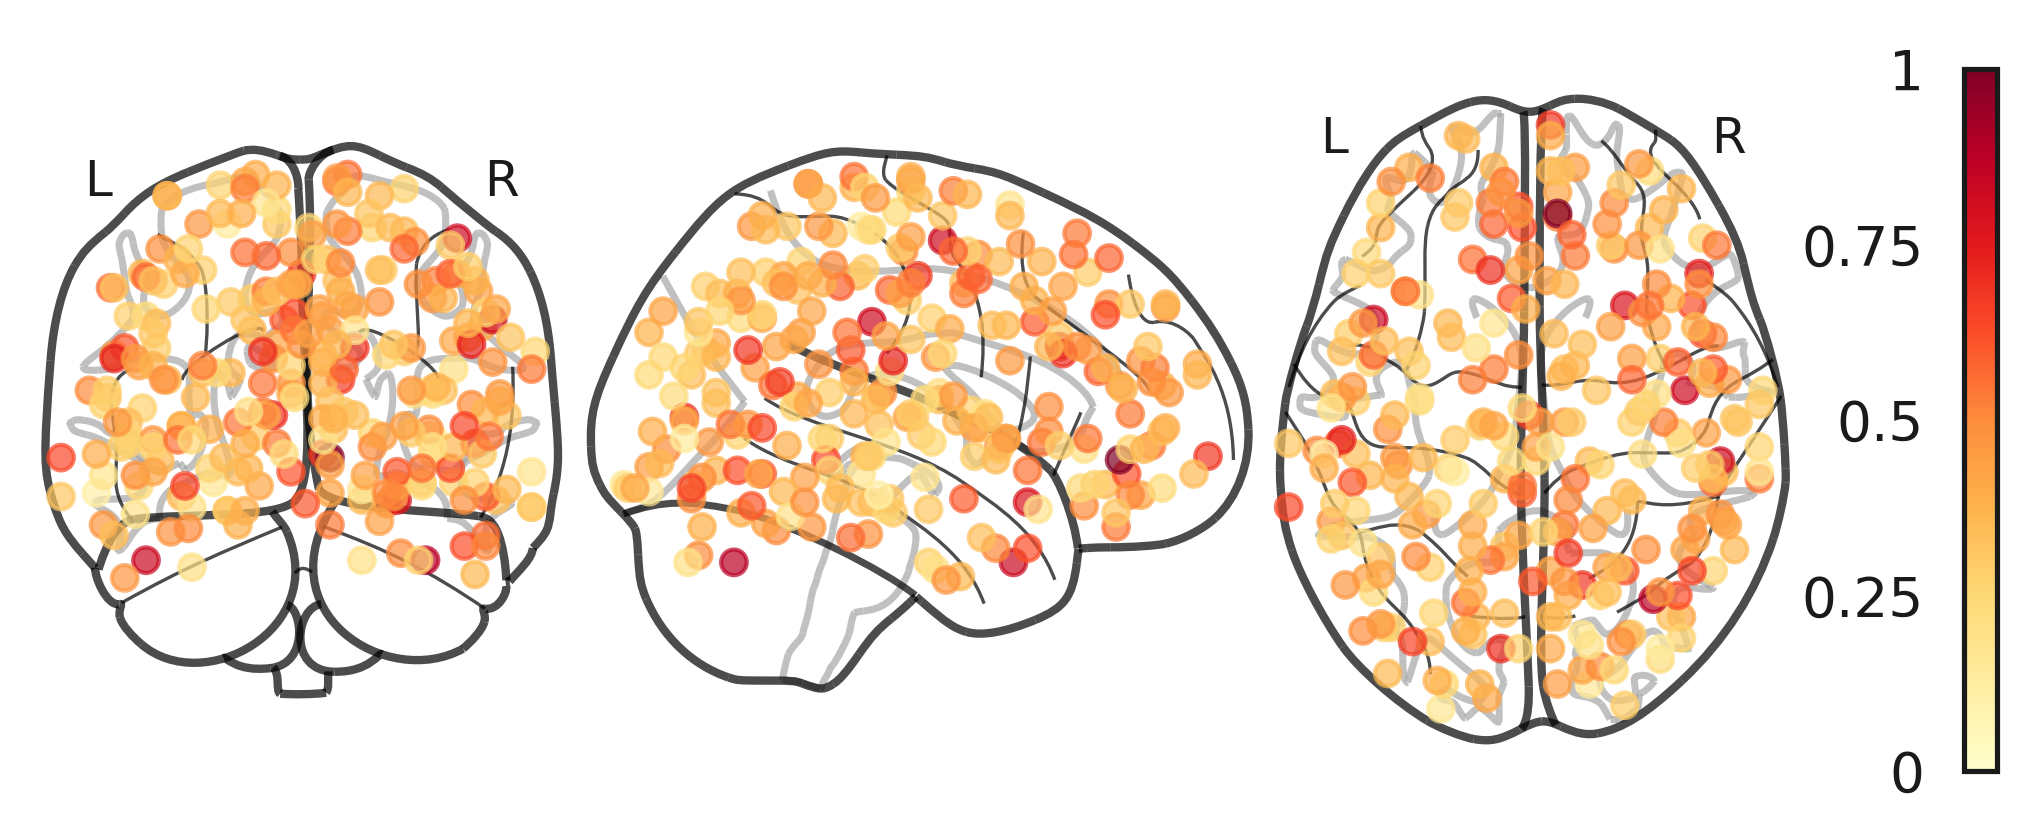

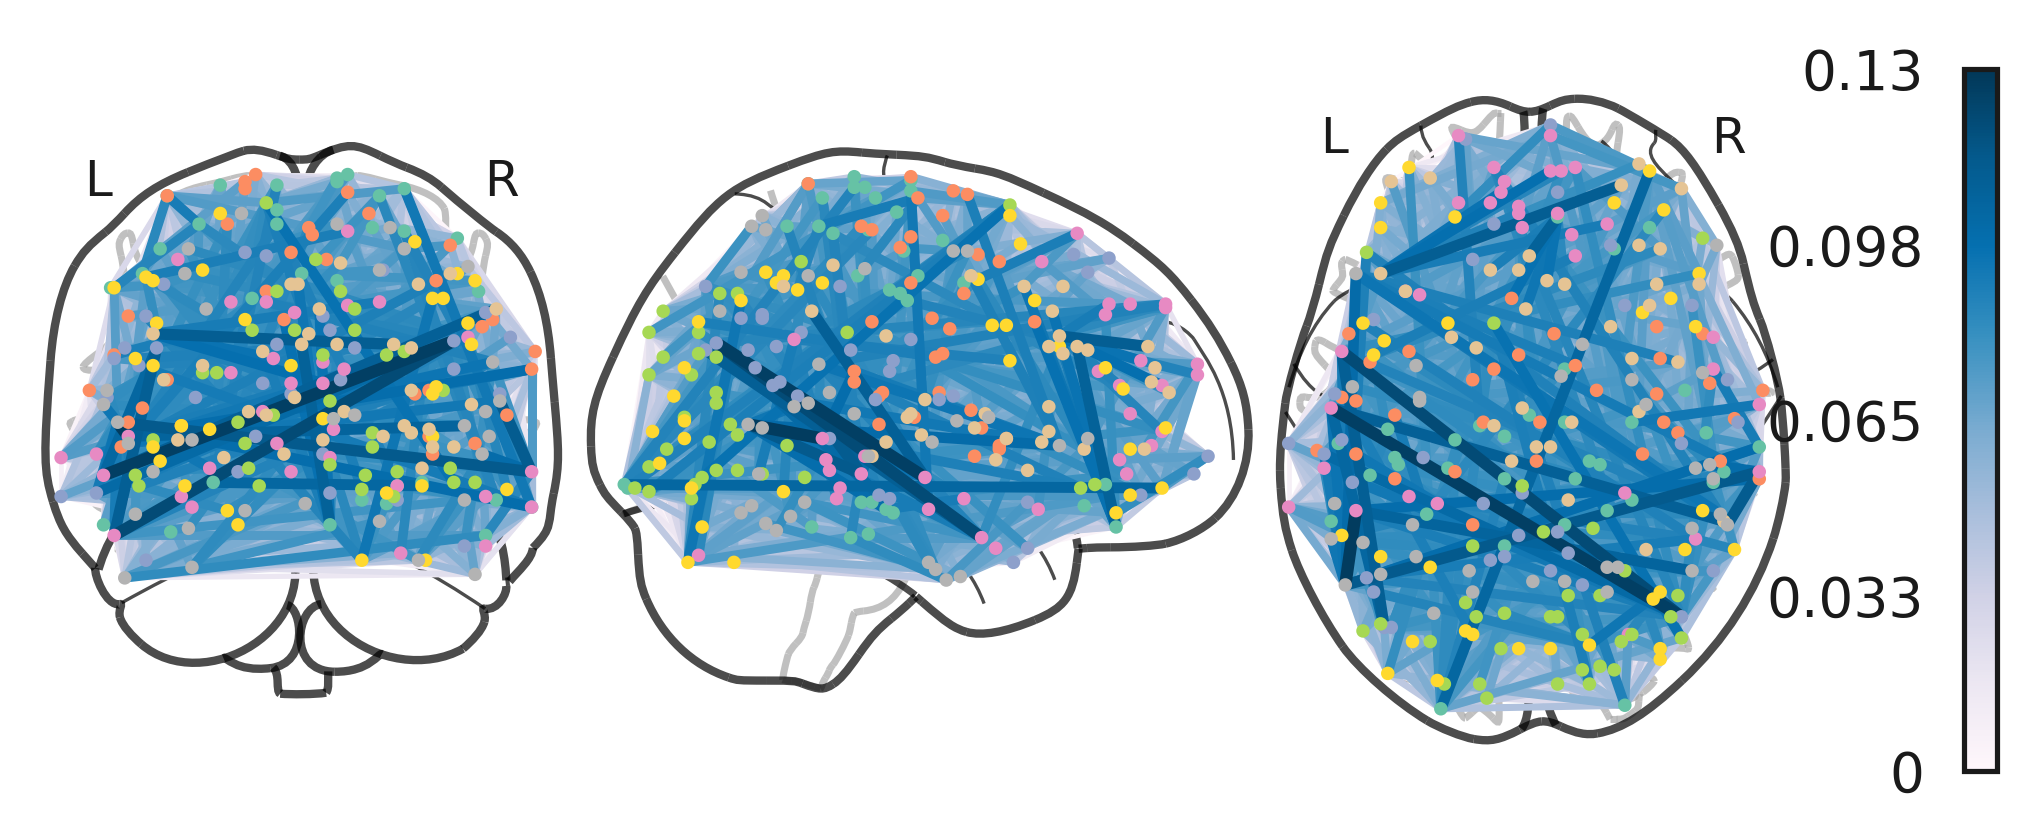

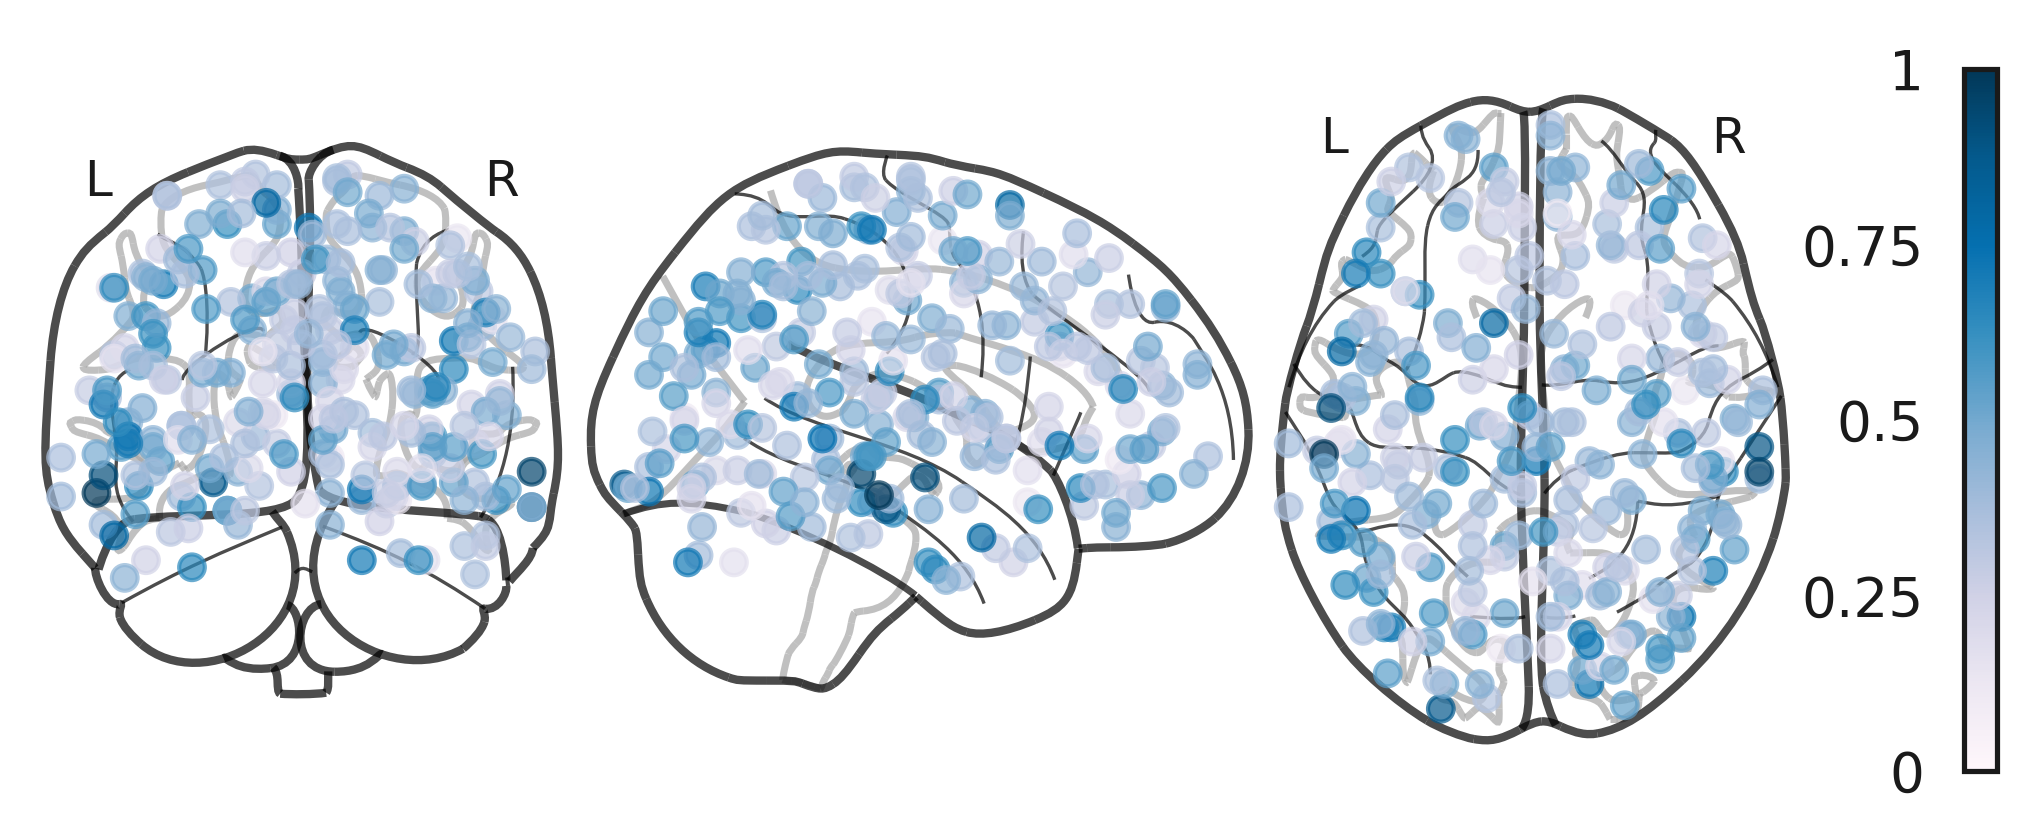

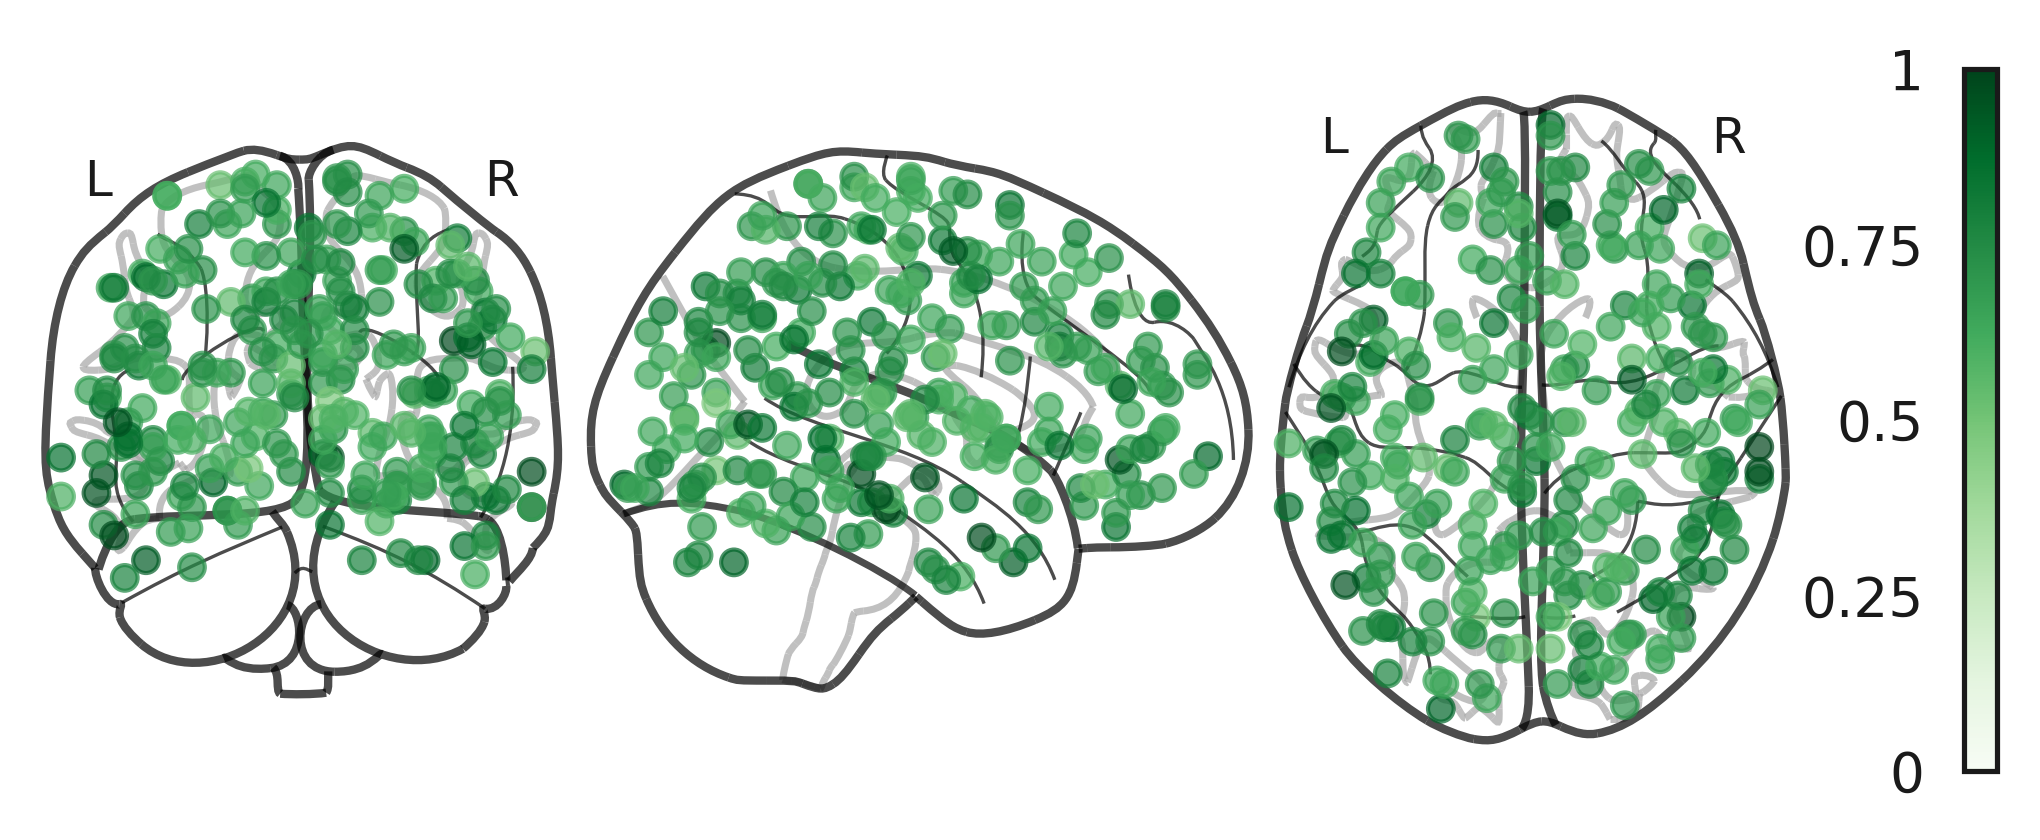

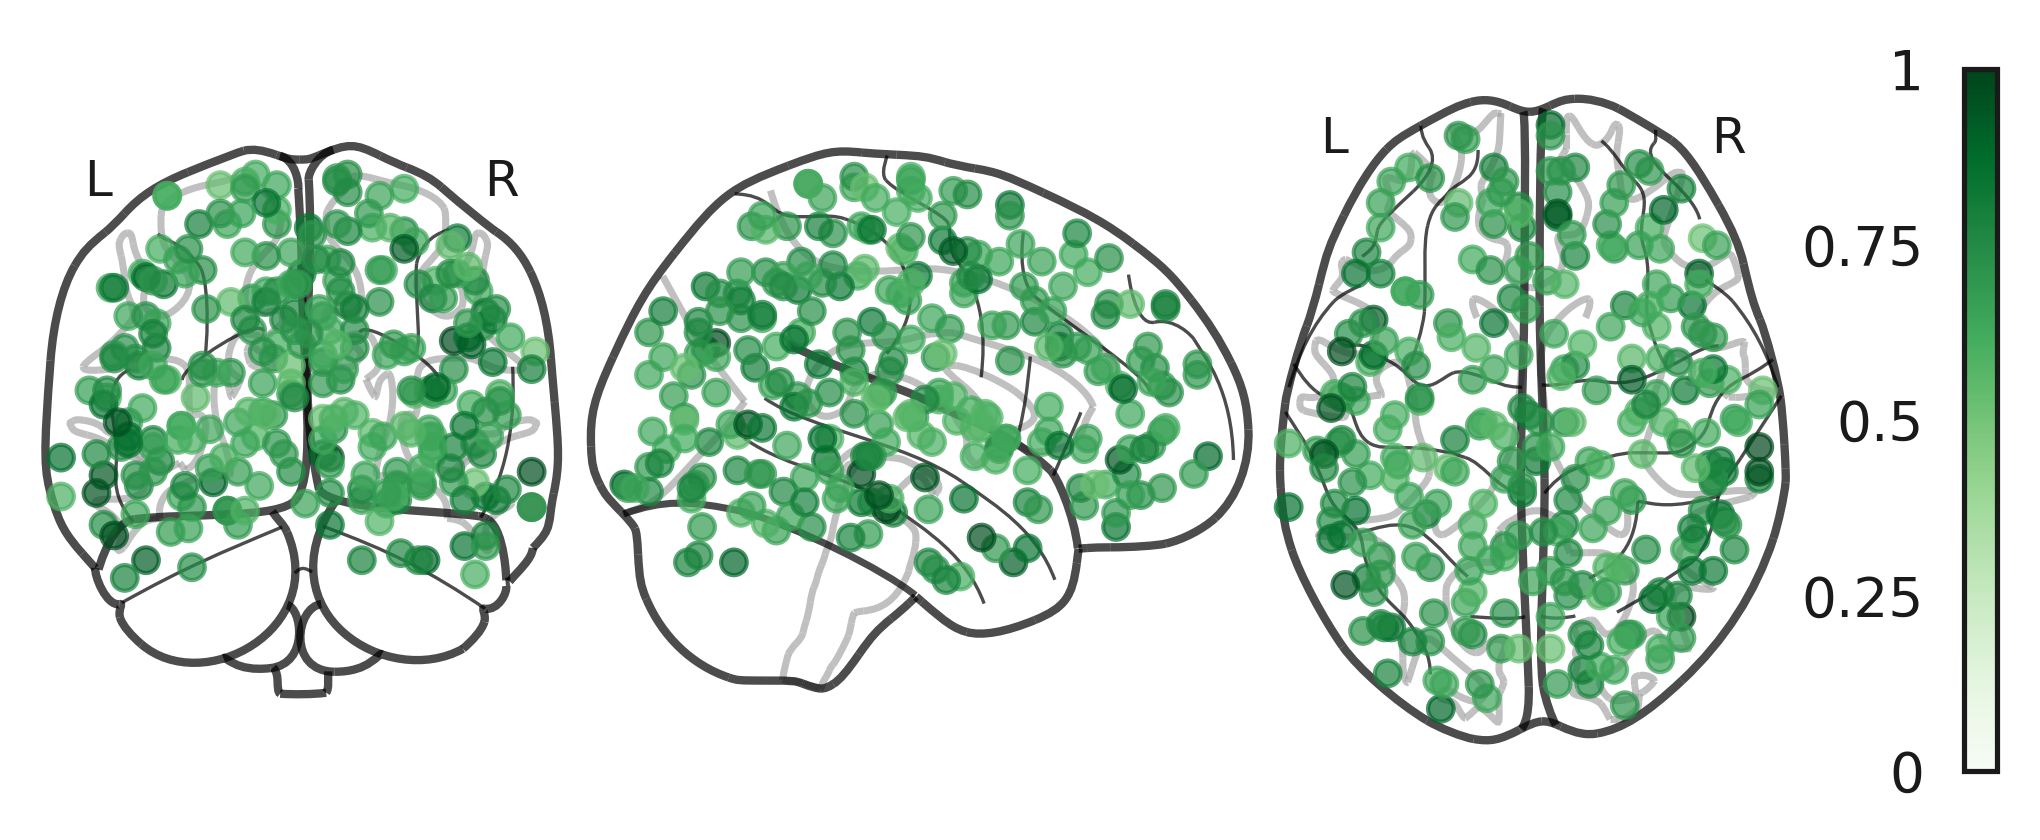

In [7]:
from common.plotting import plot_connections

selected_features = avg_coef
print(selected_features.shape, np.min(selected_features), np.max(selected_features))

plot_connections(selected_features, -0.13, 0.13, False)

### Compare ages

In [6]:
from common.calculation import (
    calc_cosine_similarity, calc_norm_euclidean, compare_age_similarity)
from common.plotting import plot_age_comparisons

In [7]:
all_ages = avg_coef

In [10]:
bin_1 = avg_coef

In [13]:
bin_2 = avg_coef

In [16]:
bin_3 = avg_coef

[[1.         0.56380355 0.58572125 0.66993278]
 [0.56380355 1.         0.12533483 0.15203735]
 [0.58572125 0.12533483 1.         0.10942699]
 [0.66993278 0.15203735 0.10942699 1.        ]]


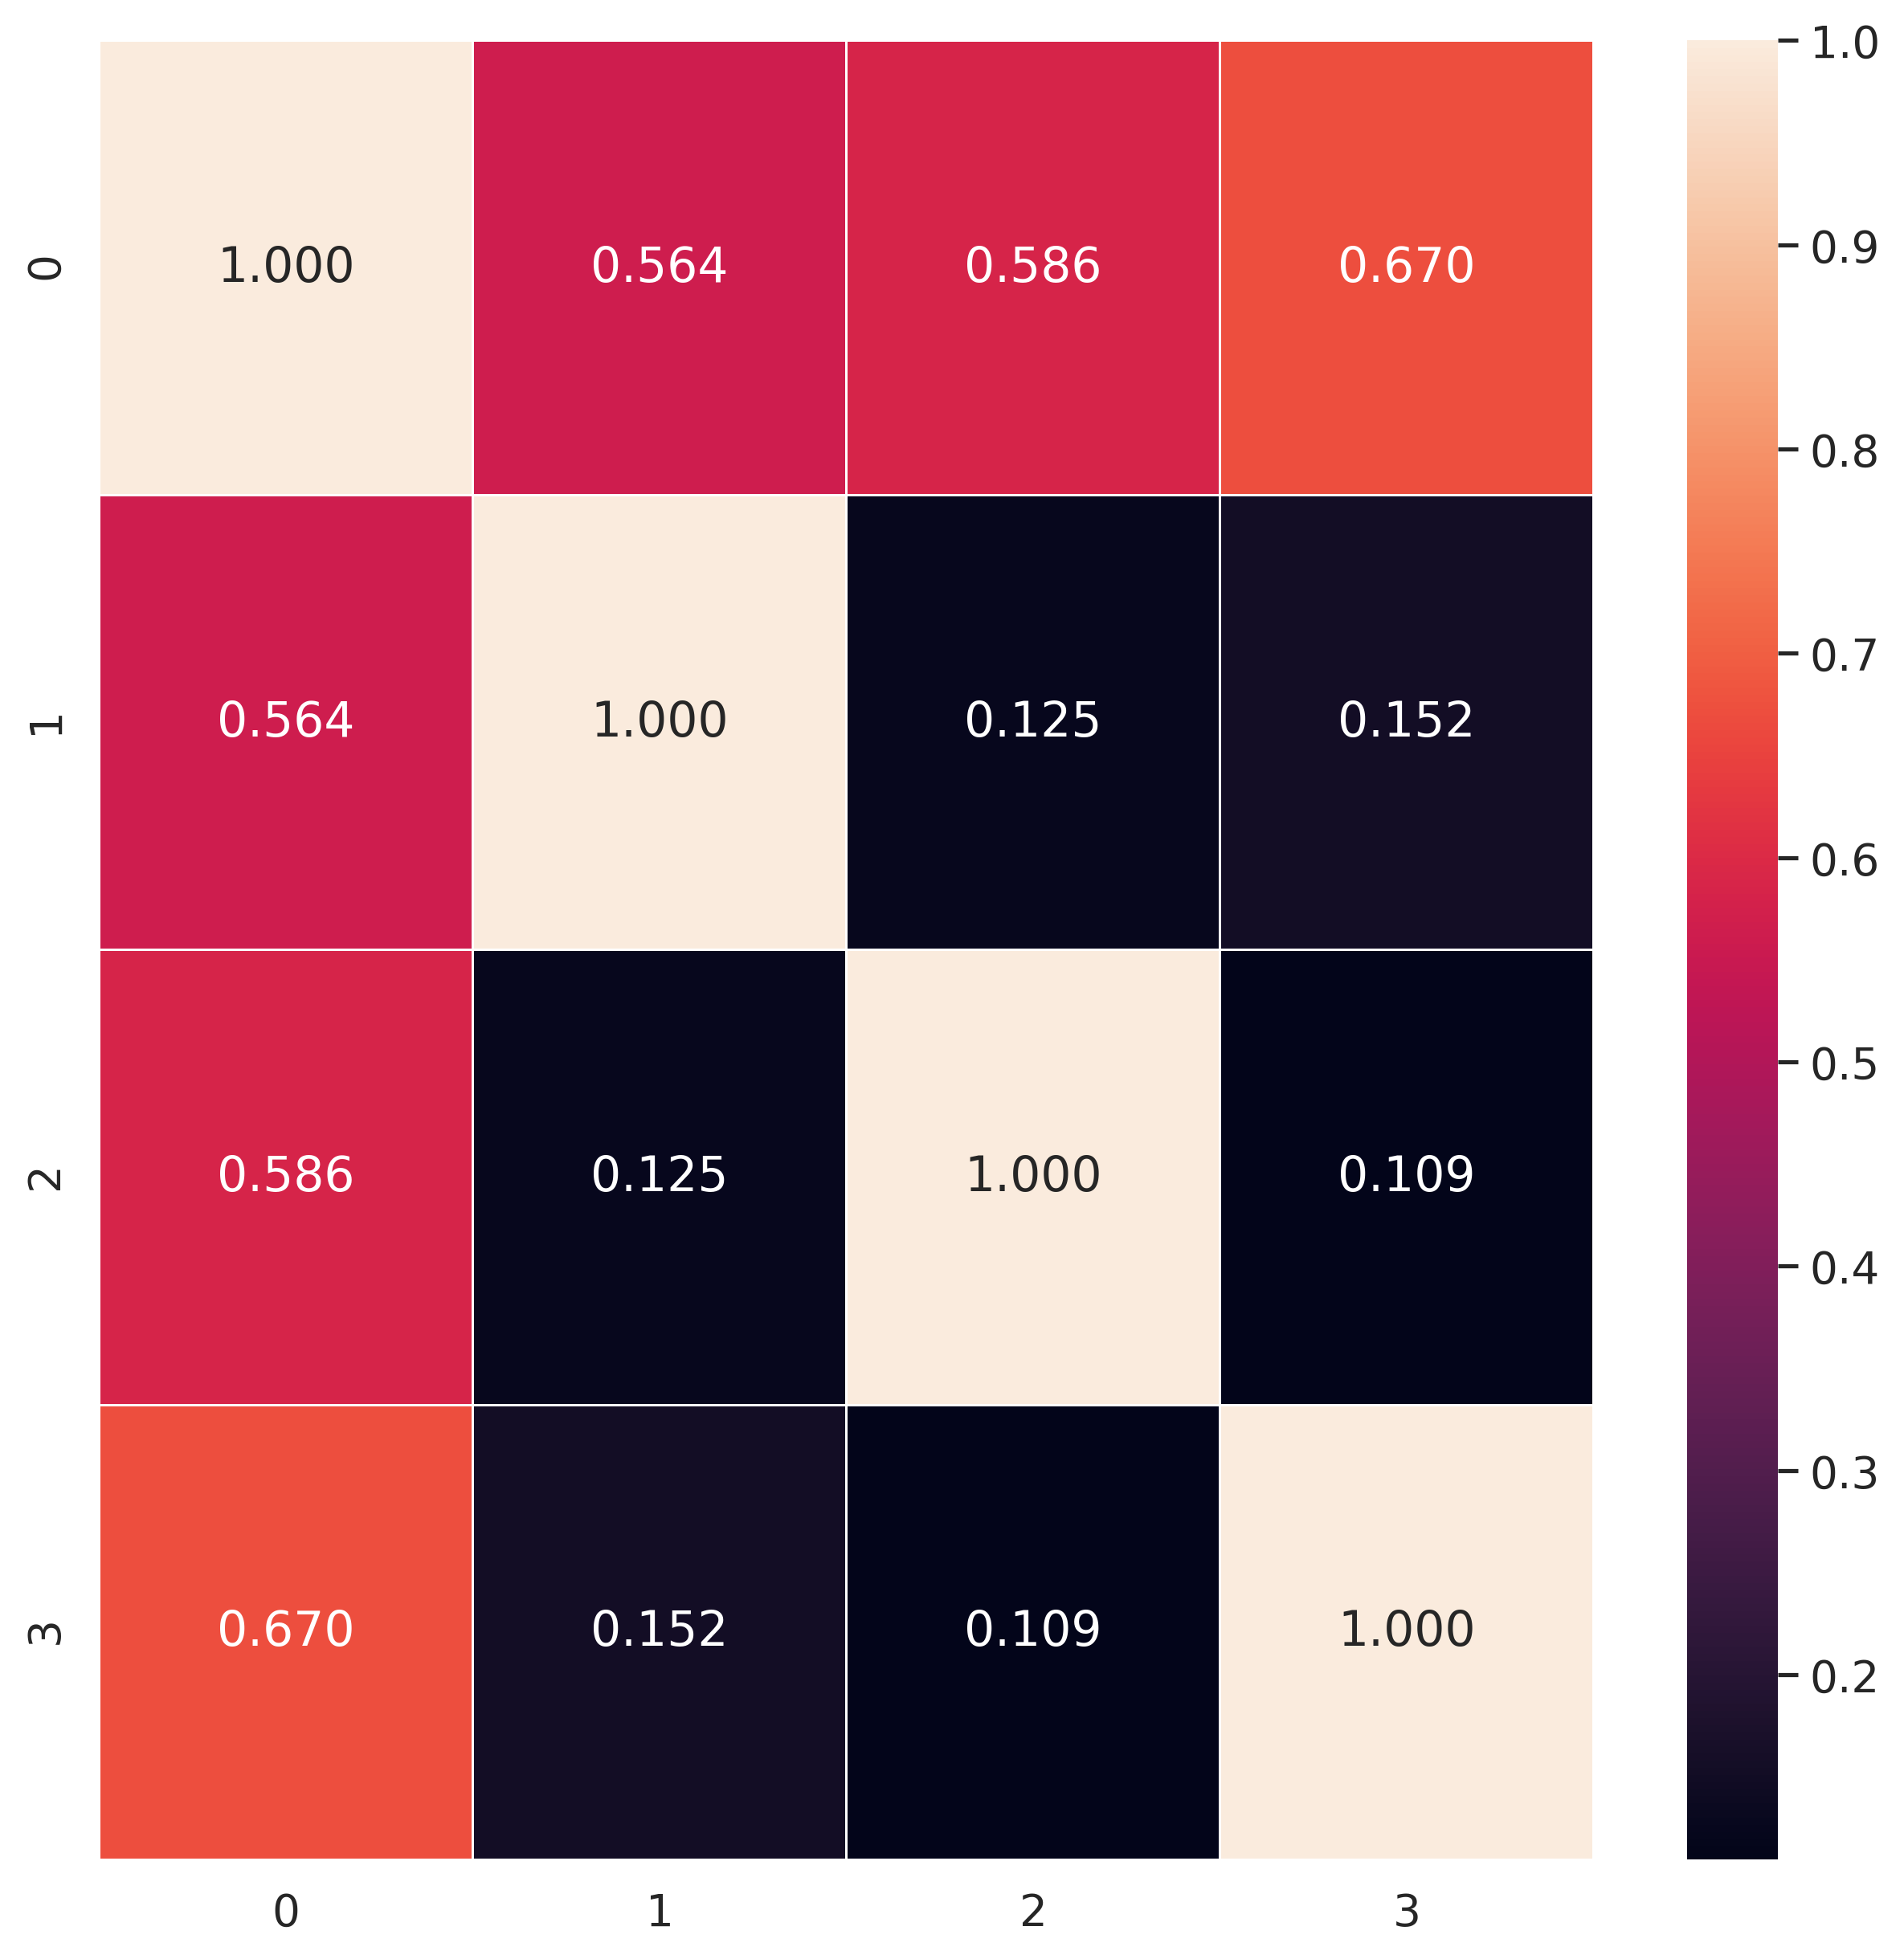

In [20]:
comparisons = compare_age_similarity(all_ages, bin_1, bin_2, bin_3, calc_cosine_similarity)
np.fill_diagonal(comparisons, 1)
print(comparisons)
plot_age_comparisons(comparisons)